In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

C:\Users\Dell\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.9.0'

In [3]:
import vgg16

In [4]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        
        factor = max_size / np.max(image.size)
        size = np.array(image.size) * factor
        size = size.astype(int)
        image = image.resize(size, PIL.Image.LANCZOS)
    return np.float32(image)

In [24]:
def plot_image_big(image):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    display(PIL.Image.fromarray(image))

In [25]:
def plot_images(content_image, style_image, mixed_image):
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    smooth = True
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

   
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")


    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

  
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [26]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [27]:
def create_content_loss(session, model, content_image, layer_ids):
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    layers = model.get_layer_tensors(layer_ids)

    values = session.run(layers, feed_dict=feed_dict)

    with model.graph.as_default():
        layer_losses = []
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(layer, value_const)
            layer_losses.append(loss)
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [28]:
def gram_matrix(tensor):
    
    shape = tensor.get_shape()
    num_channels = int(shape[3])
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram


In [29]:
def create_style_loss(session, model, style_image, layer_ids):

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    layers = model.get_layer_tensors(layer_ids)
    with model.graph.as_default():
        gram_layers = [gram_matrix(layer) for layer in layers]
        values = session.run(gram_layers, feed_dict=feed_dict)
        layer_losses = []
    
    
        for value, gram_layer in zip(values, gram_layers):
        
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)

        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [30]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [31]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):

    model = vgg16.VGG16()
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])


    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    #where we first init it
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        #Remove single-dimensional entries from the shape of an array.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        #Ratio of weights:updates
        #akin to learning rate
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        #Given an interval, values outside the interval are clipped 
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [18]:
content_filename = 'C:\\Users\\Dell\\Style_transfer_minor\\style\\japanese_painting.jpg'
content_image = load_image(content_filename, max_size=None)

In [20]:
style_filename = 'C:\\Users\\Dell\\Style_transfer_minor\\style\\style8.jpg'
style_image = load_image(style_filename, max_size=300)

In [21]:
#content_layer_ids = [6]
content_layer_ids = [4]

In [22]:
style_layer_ids = list(range(13))
# style_layer_ids = [1, 2, 3, 4]

C:\Users\Dell\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 4.80e-11, Style: 1.32e-29, Denoise: 1.23e-06


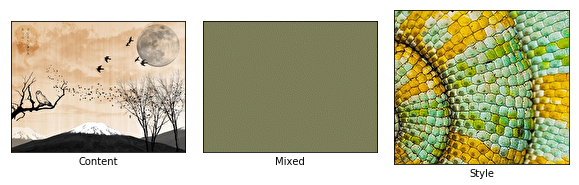

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 5.10e-11, Style: 6.76e-29, Denoise: 2.89e-08


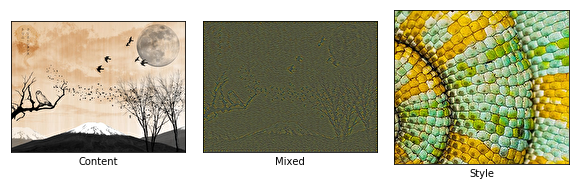

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 5.01e-11, Style: 9.54e-29, Denoise: 2.85e-08


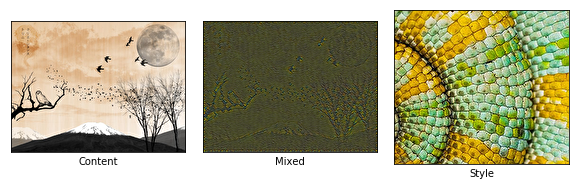

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 4.52e-11, Style: 3.46e-29, Denoise: 3.09e-08


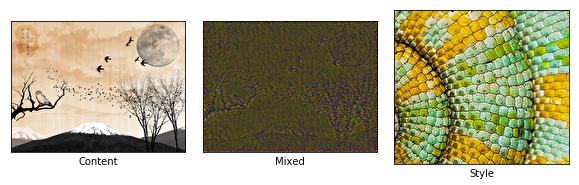

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 6.24e-11, Style: 3.34e-29, Denoise: 2.51e-08


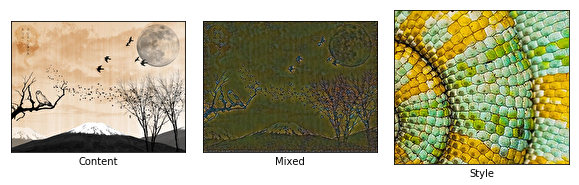

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 7.06e-11, Style: 2.57e-29, Denoise: 3.12e-08


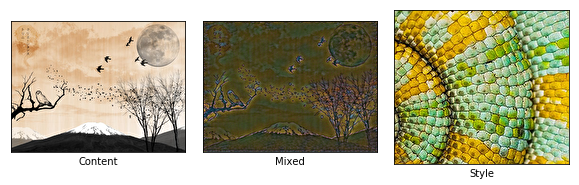

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 7.23e-11, Style: 2.59e-29, Denoise: 2.72e-08


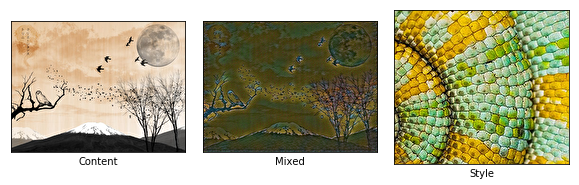

. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 7.72e-11, Style: 5.62e-29, Denoise: 3.16e-08


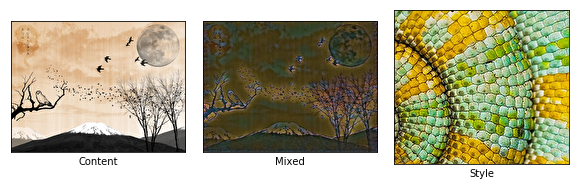

. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 7.86e-11, Style: 3.24e-29, Denoise: 2.83e-08


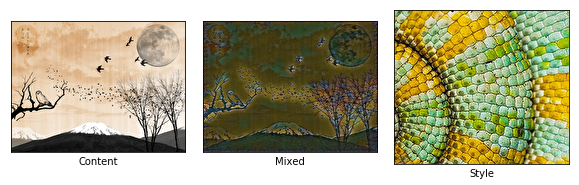

. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 6.78e-11, Style: 6.04e-29, Denoise: 2.81e-08


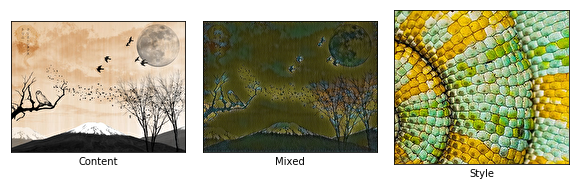

. . . . . . . . . . 
Iteration: 100
Weight Adj. for Content: 6.26e-11, Style: 9.05e-29, Denoise: 2.97e-08


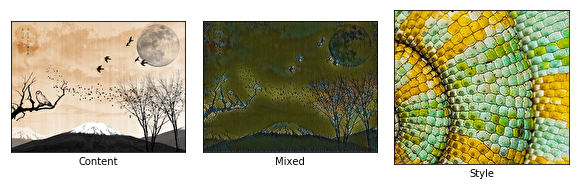

. . . . . . . . . . 
Iteration: 110
Weight Adj. for Content: 6.02e-11, Style: 1.01e-28, Denoise: 2.96e-08


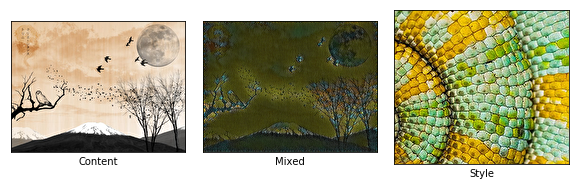

. . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 5.87e-11, Style: 1.04e-28, Denoise: 2.90e-08


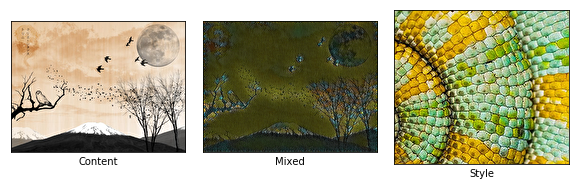

. . . . . . . . . . 
Iteration: 130
Weight Adj. for Content: 5.74e-11, Style: 9.93e-29, Denoise: 2.81e-08


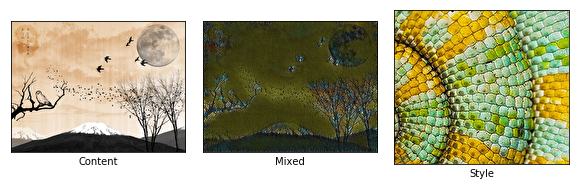

. . . . . . . . . . 
Iteration: 140
Weight Adj. for Content: 5.67e-11, Style: 9.24e-29, Denoise: 2.76e-08


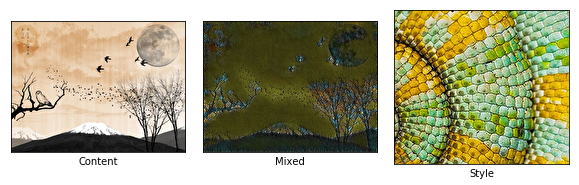

. . . . . . . . . . 
Iteration: 150
Weight Adj. for Content: 5.64e-11, Style: 9.04e-29, Denoise: 2.73e-08


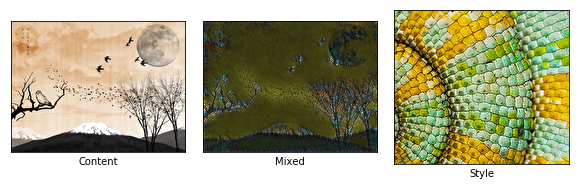

. . . . . . . . . . 
Iteration: 160
Weight Adj. for Content: 5.62e-11, Style: 9.04e-29, Denoise: 2.72e-08


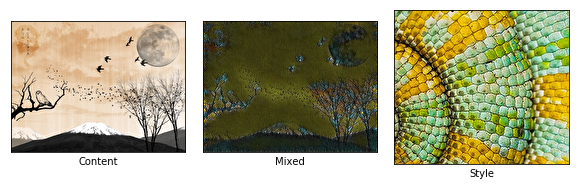

. . . . . . . . . . 
Iteration: 170
Weight Adj. for Content: 5.59e-11, Style: 9.10e-29, Denoise: 2.70e-08


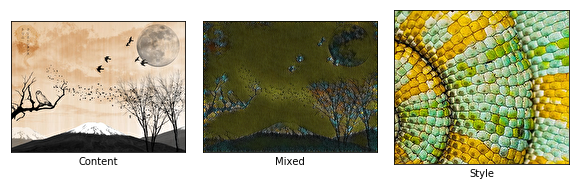

. . . . . . . . . . 
Iteration: 180
Weight Adj. for Content: 5.58e-11, Style: 9.13e-29, Denoise: 2.69e-08


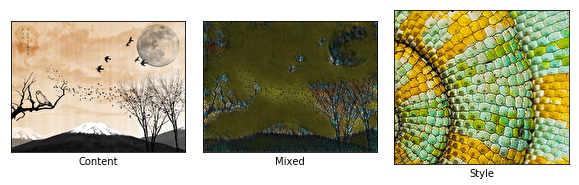

. . . . . . . . . . 
Iteration: 190
Weight Adj. for Content: 5.56e-11, Style: 9.19e-29, Denoise: 2.68e-08


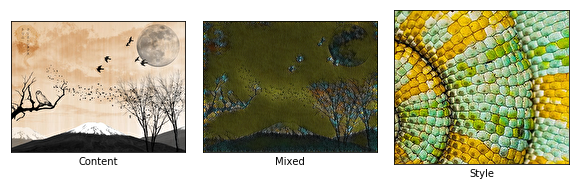

. . . . . . . . . . 
Iteration: 200
Weight Adj. for Content: 5.55e-11, Style: 9.21e-29, Denoise: 2.66e-08


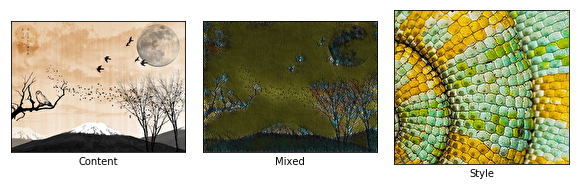

. . . . . . . . . . 
Iteration: 210
Weight Adj. for Content: 5.54e-11, Style: 9.22e-29, Denoise: 2.65e-08


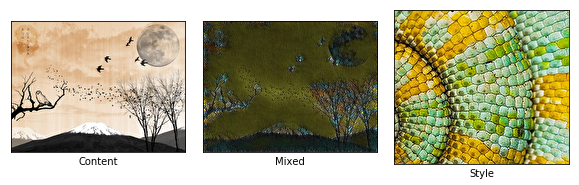

. . . . . . . . . . 
Iteration: 220
Weight Adj. for Content: 5.53e-11, Style: 9.42e-29, Denoise: 2.65e-08


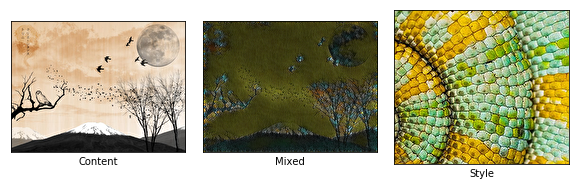

. . . . . . . . . . 
Iteration: 230
Weight Adj. for Content: 5.51e-11, Style: 9.53e-29, Denoise: 2.64e-08


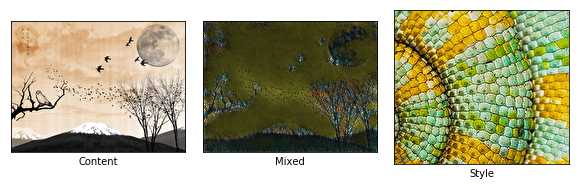

. . . . . . . . . . 
Iteration: 240
Weight Adj. for Content: 5.50e-11, Style: 9.50e-29, Denoise: 2.63e-08


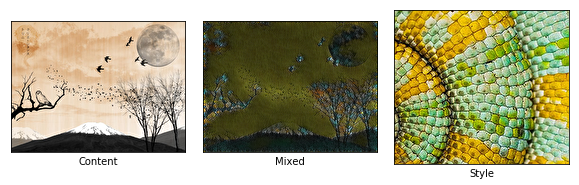

. . . . . . . . . . 
Iteration: 250
Weight Adj. for Content: 5.49e-11, Style: 9.43e-29, Denoise: 2.62e-08


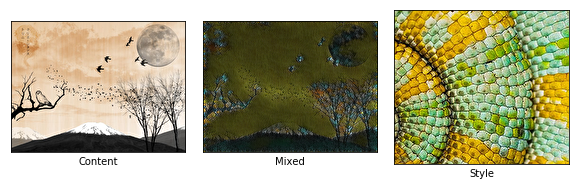

. . . . . . . . . . 
Iteration: 260
Weight Adj. for Content: 5.49e-11, Style: 9.46e-29, Denoise: 2.61e-08


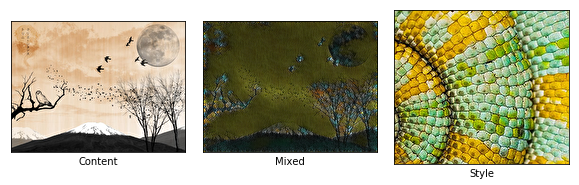

. . . . . . . . . . 
Iteration: 270
Weight Adj. for Content: 5.48e-11, Style: 9.59e-29, Denoise: 2.61e-08


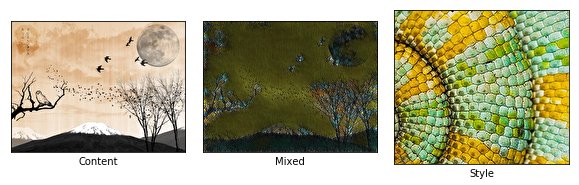

. . . . . . . . . . 
Iteration: 280
Weight Adj. for Content: 5.48e-11, Style: 9.67e-29, Denoise: 2.60e-08


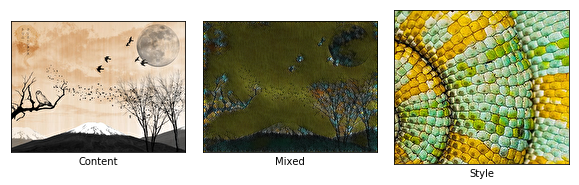

. . . . . . . . . . 
Iteration: 290
Weight Adj. for Content: 5.48e-11, Style: 9.80e-29, Denoise: 2.60e-08


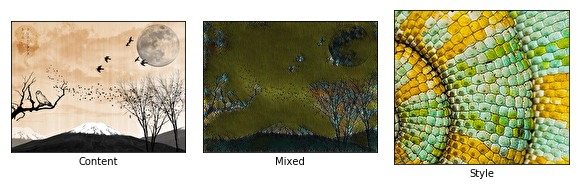

. . . . . . . . . 
Iteration: 299
Weight Adj. for Content: 5.57e-11, Style: 1.20e-28, Denoise: 2.72e-08


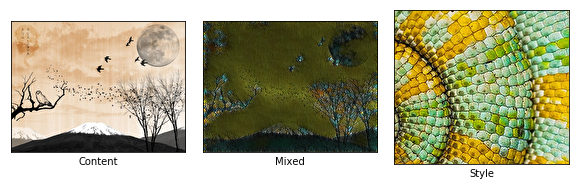


Final image:


NameError: name 'plot_image_big' is not defined

In [23]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=300,
                     step_size=20.0)